In [736]:
# Importando bibliotecas
import pandas as pd
import numpy as np
from collections import Counter

from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB

# Importar a biblioteca para mostrar a matriz de confusão
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Importando bibliotecas para calcular métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Plotar gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# Balanceamento
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import AllKNN
from imblearn.over_sampling import SMOTE

In [737]:
# Ler dados do DataSet
csv_dir_treinamento = "/content/sample_data/labor.csv"
data = pd.read_csv(csv_dir_treinamento, delimiter=",")

In [738]:
# Remover a coluna TBG onde todos os valores são NaN
data.drop(["TBG"], axis=1, inplace=True)

# Atualizar ? para NaN
data = data.mask(data == '?')

In [739]:
# Atualizar NaN para o modo da coluna
data.dropna(subset=['age'], inplace=True, axis=0) # Remover a unica linha nula de idade
# Atualizar valores moda:
data.fillna(data['sex'].mode(), inplace=True)
# Atualizar valores media:
colunas_nulas_media = ["TSH", "T3", "TT4", "T4U", "FTI"]
for column in colunas_nulas_media:
    data[column].fillna(data[column].mode()[0], inplace=True)

In [740]:
# Contar a quantidade de instancias na classificação
Counter(data['Class'])

Counter({'negative': 3480,
         'compensated_hypothyroid': 194,
         'primary_hypothyroid': 95,
         'secondary_hypothyroid': 2})

In [741]:
# Remover a instância que tem 2 resultados (muito pequena)
indexNames = data[(data['Class'] == 'secondary_hypothyroid')].index
data.drop(indexNames, inplace=True)

In [742]:
# Tratar dados nominais para númericos (Treinamento)
treinamento_classification = data['Class']
data.drop(["Class"], axis=1, inplace=True)
treinamento_dados = pd.get_dummies(data, columns=["'referral source'"])
data.drop(["'referral source'"], axis=1, inplace=True)

In [743]:
# Atualizar tabela com binários
labelencoder =  preprocessing.LabelEncoder()
# node-caps: faltantes
for column in data.columns:
  treinamento_dados[column] = labelencoder.fit_transform(treinamento_dados[column])

In [744]:
# Separar dados de treinamento e de testes
dataset_treino, dataset_teste, dataset_treino_class, dataset_teste_class = train_test_split(treinamento_dados, treinamento_classification, test_size=0.30, random_state=0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


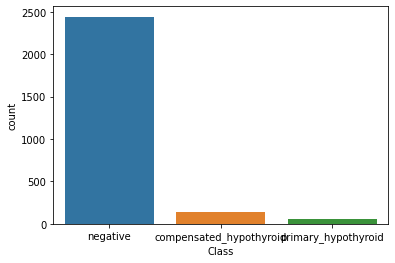

In [745]:
sns.countplot(dataset_treino_class)

In [746]:
# Contar a quantidade de instancias na classificação, conferindo se foi removido
Counter(dataset_treino_class)

Counter({'negative': 2442,
         'compensated_hypothyroid': 135,
         'primary_hypothyroid': 61})

In [747]:
# Fazer o balanceamento no dado principal, para o dataset de treino nao ficar sem dados de classificação
under_over = SMOTEENN(random_state=0)
dataset_treino, dataset_treino_class = under_over.fit_resample(dataset_treino, dataset_treino_class)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


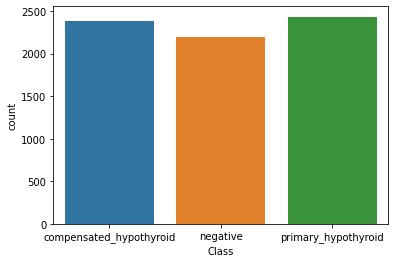

In [748]:
sns.countplot(dataset_treino_class)

In [749]:
# Criar e treinar árvore de decisão
tree_data = DecisionTreeClassifier(criterion="entropy")
tree_data.fit(dataset_treino, dataset_treino_class)

DecisionTreeClassifier(criterion='entropy')

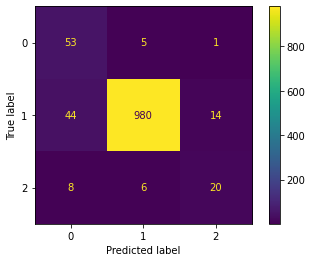

In [750]:
conf_matrix = confusion_matrix(dataset_teste_class, tree_data.predict(dataset_teste))
cmd = ConfusionMatrixDisplay(conf_matrix)
cmd.plot(values_format="d")
plt.show()

In [751]:
# Mostrar métricas
print('Árvore')
print("Accuracy score = ", accuracy_score(dataset_teste_class, tree_data.predict(dataset_teste)))
print(classification_report(dataset_teste_class, tree_data.predict(dataset_teste)))

Árvore
Accuracy score =  0.9310344827586207
                         precision    recall  f1-score   support

compensated_hypothyroid       0.50      0.90      0.65        59
               negative       0.99      0.94      0.97      1038
    primary_hypothyroid       0.57      0.59      0.58        34

               accuracy                           0.93      1131
              macro avg       0.69      0.81      0.73      1131
           weighted avg       0.95      0.93      0.94      1131



In [752]:
# Criar e treinar Naive Bayes
gnb = GaussianNB()
gnb.fit(dataset_treino, dataset_treino_class)

GaussianNB()

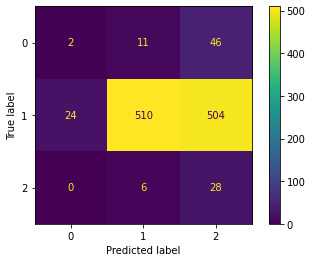

In [753]:
conf_matrix = confusion_matrix(dataset_teste_class, gnb.predict(dataset_teste))
cmd = ConfusionMatrixDisplay(conf_matrix)
cmd.plot(values_format="d")
plt.show()

In [754]:
# Mostrar métricas
print('Naive Bayes')
print("Accuracy score = ", accuracy_score(dataset_teste_class, gnb.predict(dataset_teste)))
print(classification_report(dataset_teste_class, gnb.predict(dataset_teste)))

Naive Bayes
Accuracy score =  0.47745358090185674
                         precision    recall  f1-score   support

compensated_hypothyroid       0.08      0.03      0.05        59
               negative       0.97      0.49      0.65      1038
    primary_hypothyroid       0.05      0.82      0.09        34

               accuracy                           0.48      1131
              macro avg       0.36      0.45      0.26      1131
           weighted avg       0.89      0.48      0.60      1131



In [755]:
rforest = RandomForestClassifier(max_features=6, criterion='gini', random_state=0)
rforest.fit(dataset_treino, dataset_treino_class)

RandomForestClassifier(max_features=6, random_state=0)

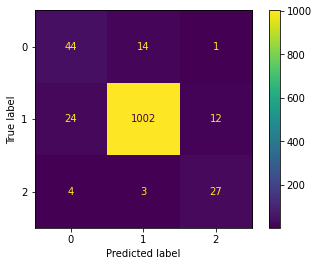

In [756]:
conf_matrix = confusion_matrix(dataset_teste_class, rforest.predict(dataset_teste))
cmd = ConfusionMatrixDisplay(conf_matrix)
cmd.plot(values_format="d")
plt.show()

In [757]:
# Mostrar métricas
print('Random Forest')
print("Accuracy score = ", accuracy_score(dataset_teste_class, rforest.predict(dataset_teste)))
print(classification_report(dataset_teste_class, rforest.predict(dataset_teste)))

Random Forest
Accuracy score =  0.9487179487179487
                         precision    recall  f1-score   support

compensated_hypothyroid       0.61      0.75      0.67        59
               negative       0.98      0.97      0.97      1038
    primary_hypothyroid       0.68      0.79      0.73        34

               accuracy                           0.95      1131
              macro avg       0.76      0.84      0.79      1131
           weighted avg       0.95      0.95      0.95      1131

